# Аналитика доходности тарифов сотовой связи 

«Мегалайн» — федеральный оператор сотовой связи. Компания предлагает клиентам два тарифных плана: «Смарт» и «Ультра»

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  
В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Предварительный анализ данных

### Описание данных  
**Таблица users (информация о пользователях):**  
- user_id — уникальный идентификатор пользователя  
- first_name — имя пользователя  
- last_name — фамилия пользователя  
- age — возраст пользователя (годы)  
- reg_date — дата подключения тарифа (день, месяц, год)  
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
- city — город проживания пользователя  
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**  
- id — уникальный номер звонка  
- call_date — дата звонка  
- duration — длительность звонка в минутах  
- user_id — идентификатор пользователя, сделавшего звонок  

**Таблица messages (информация о сообщениях):**  
- id — уникальный номер сообщения  
- message_date — дата сообщения  
- user_id — идентификатор пользователя, отправившего сообщение  

**Таблица internet (информация об интернет-сессиях):**  
- id — уникальный номер сессии  
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)  
- session_date — дата интернет-сессии  
- user_id — идентификатор пользователя  

**Таблица tariffs (информация о тарифах):**  
- tariff_name — название тарифа  
- rub_monthly_fee — ежемесячная абонентская плата в рублях  
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату  
- messages_included — количество сообщений в месяц, включённых в абонентскую плату  
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета  
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Предобработка данных

Импортируем все необходимые библиотеки Python для дальнейшего анализа данных

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mt
from math import factorial
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
users = pd.read_csv('/datasets/users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
display(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Проверим данные на пропуски, наличие дубликатов и вбросов.

In [5]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Пропуски присутсвуют только в колонке churn_date, но это не отсутсвие данных, а важный показатель.  

In [6]:
users.duplicated().sum()

0

Явных дубликатов в выборке не обнаружено.

In [7]:
users.describe()

,user_id,age
count,500.00,500.00
mean,"1,249.50",46.59
std,144.48,16.67
min,"1,000.00",18.00
25%,"1,124.75",32.00
50%,"1,249.50",46.00
75%,"1,374.25",62.00
max,"1,499.00",75.00


Вбросы в данных тоже отствуют, следовательно выборка готова к дальнейшему анализу данных.

In [8]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
display(calls)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Проверим данные на пропуски, наличие дубликатов и вбросов.

In [10]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [11]:
calls.duplicated().sum()

0

In [12]:
calls.describe()

,duration,user_id
count,"202,607.00","202,607.00"
mean,6.76,"1,253.94"
std,5.84,144.72
min,0.00,"1,000.00"
25%,1.30,"1,126.00"
50%,6.00,"1,260.00"
75%,10.70,"1,379.00"
max,38.00,"1,499.00"


В выборке calls так же отсутсвуют пропуски, дубликаты и вбросы.

In [13]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
display(messages)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [15]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [16]:
messages.duplicated().sum()

0

In [17]:
messages.describe()

,user_id
count,"123,036.00"
mean,"1,256.99"
std,143.52
min,"1,000.00"
25%,"1,134.00"
50%,"1,271.00"
75%,"1,381.00"
max,"1,499.00"


В выборке messages так же отсутсвуют пропуски, дубликаты и вбросы.

In [18]:
internet = pd.read_csv('/datasets/internet.csv', index_col=[0])
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [19]:
display(internet)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,"1,246.32",2018-11-26,1499


In [20]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [21]:
internet.duplicated().sum()

0

In [22]:
internet.describe()

,mb_used,user_id
count,"149,396.00","149,396.00"
mean,370.19,"1,252.10"
std,278.30,144.05
min,0.00,"1,000.00"
25%,138.19,"1,130.00"
50%,348.01,"1,251.00"
75%,559.55,"1,380.00"
max,"1,724.83","1,499.00"


В выборке internet так же отсутсвуют пропуски, дубликаты и вбросы.

In [23]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [24]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

In [26]:
tariffs.duplicated().sum()

0

In [27]:
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.00,2.00,2.00,2.00,2.00,2.00,2.00
mean,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
std,671.75,"10,861.16","1,767.77",989.95,35.36,1.41,1.41
min,50.00,"15,360.00",500.00,550.00,150.00,1.00,1.00
25%,287.50,"19,200.00","1,125.00",900.00,162.50,1.50,1.50
50%,525.00,"23,040.00","1,750.00","1,250.00",175.00,2.00,2.00
75%,762.50,"26,880.00","2,375.00","1,600.00",187.50,2.50,2.50
max,"1,000.00","30,720.00","3,000.00","1,950.00",200.00,3.00,3.00


**Описание тарифов**

**Тариф «Смарт»**  
Ежемесячная плата: 550 рублей.  
Включено: 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета:  
1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута);  
2. сообщение: 3 рубля;  
3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**  
Ежемесячная плата: 1950 рублей.  
Включено: 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика.  
Стоимость услуг сверх тарифного пакета: 
1. минута разговора: 1 рубль; 
2. сообщение: 1 рубль; 
3. 1 Гб интернет-трафика: 150 рублей.



Есть важное замечание для дальнейших расчетов. В таблице tariffs включенный в тариф трафик интернета считается в мегабайтах, а плата считается за каждый гигабайт. Поэтому добавим столбец в таблитцу tariffs, где посчитаем количество трафика в тарифе в гигабайтах.

In [28]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.00
1,1000,30720,3000,1950,150,1,1,ultra,30.00


Во всех таблицах выше не правильно указан тип данных для даты и времени, необходимо привести к типу данных datetime.

In [29]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Рассчеты для пользователей

В проекте необходимо посчитать для каждого пользователя следующие показатели:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.  
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Для решения поставленных задач в каждую таблицу с данными по объему минут, сообщений и трафика добавим столбец с месяцем, т.к. данные в них приведены за 2018 год и сгруппируем по пользователю и месяцу соответствующие необходимые метрики.

In [30]:
calls['month'] = calls['call_date'].dt.month
calls['duration_ceil']=calls['duration'].apply(mt.ceil) 
calls_id = calls.groupby(['user_id','month'])['duration_ceil'].agg(['count','sum'])
calls_id = calls_id.reset_index().rename(columns={'count':'call_count', 'sum':'minutes'})

In [31]:
messages['month'] = messages['message_date'].dt.month
messages_id = messages.groupby(['user_id','month'])['id'].count()
messages_id = messages_id.reset_index().rename(columns={'id':'messages'})

In [32]:
internet['month'] = internet['session_date'].dt.month
internet_id = internet.groupby(['user_id','month'])['mb_used'].sum()
internet_id = internet_id.reset_index()
internet_id['gb_used'] = internet_id['mb_used']/1024
internet_id['gb_used'] = internet_id['gb_used'].apply(mt.ceil) 

Для расчета ежемесячной выручки, полученной от каждого пользователя, объединим все необходимые таблицы и произведем рассчеты в соответствии с условиями тарифа.

In [33]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'}) # для дальнейшего объединения по полю 

users_stat = (
    calls_id
    .merge(messages_id, on=('user_id','month'), how='outer')
    .merge(internet_id, on=('user_id','month'), how='outer')
    .merge(users[['user_id','city','tariff']], on=('user_id'))
    .merge(tariffs, on=('tariff'))
)

display(users_stat)

,user_id,month,call_count,minutes,messages,mb_used,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5,22.00,159.00,22.00,"2,253.49",3.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00
1,1000,6,43.00,172.00,60.00,"23,233.77",23.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00
2,1000,7,47.00,340.00,75.00,"14,003.64",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00
3,1000,8,52.00,408.00,81.00,"14,055.93",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00
4,1000,9,58.00,466.00,57.00,"14,568.91",15.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,nan,nan,17.00,"11,050.56",11.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00
3210,1489,9,nan,nan,32.00,"17,206.30",17.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00
3211,1489,10,nan,nan,21.00,"19,559.44",20.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00
3212,1489,11,nan,nan,20.00,"17,491.56",18.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00


Исходя из условий оплаты для каждого тарифа составим функцию, которая посчитает итоговый чек от каждого пользователя.

In [34]:
def revenue(row):
    if row['tariff'] == 'ultra':
        rev = 1950
        if row['minutes']>row['minutes_included']:
            rev = rev + (row['minutes']-row['minutes_included'])*row['rub_per_minute']
        if row['messages']>row['messages_included']:
            rev = rev + (row['messages']-row['messages_included'])*row['rub_per_message']
        if row['mb_used']>row['mb_per_month_included']:
            rev = rev + (row['gb_used']-row['gb_per_month_included'])*row['rub_per_gb']
        return rev
    else:
        rev = 550
        if row['minutes']>row['minutes_included']:
            rev = rev + (row['minutes']-row['minutes_included'])*row['rub_per_minute']
        if row['messages']>row['messages_included']:
            rev = rev + (row['messages']-row['messages_included'])*row['rub_per_message']
        if row['mb_used']>row['mb_per_month_included']:
            rev = rev + (row['gb_used']-row['gb_per_month_included'])*row['rub_per_gb']
        return rev
users_stat['revenue'] = users_stat.apply(revenue, axis=1)    

display(users_stat)

,user_id,month,call_count,minutes,messages,mb_used,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,1000,5,22.00,159.00,22.00,"2,253.49",3.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
1,1000,6,43.00,172.00,60.00,"23,233.77",23.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
2,1000,7,47.00,340.00,75.00,"14,003.64",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
3,1000,8,52.00,408.00,81.00,"14,055.93",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
4,1000,9,58.00,466.00,57.00,"14,568.91",15.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,nan,nan,17.00,"11,050.56",11.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,550.00
3210,1489,9,nan,nan,32.00,"17,206.30",17.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,950.00
3211,1489,10,nan,nan,21.00,"19,559.44",20.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,"1,550.00"
3212,1489,11,nan,nan,20.00,"17,491.56",18.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,"1,150.00"


Необходимо описать поведение клиентов оператора, исходя из выборки.  
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
Посчитать среднее количество, дисперсию и стандартное отклонение.  
Построить гистограммы и описать распределения.

Создадим два датафрейма для каждого тарифа.

In [35]:
users_stat_ultra = users_stat[users_stat['tariff'] == 'ultra'].copy()
users_stat_smart = users_stat[users_stat['tariff'] == 'smart'].copy()

In [36]:
display(users_stat_ultra)

,user_id,month,call_count,minutes,messages,mb_used,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,1000,5,22.00,159.00,22.00,"2,253.49",3.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
1,1000,6,43.00,172.00,60.00,"23,233.77",23.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
2,1000,7,47.00,340.00,75.00,"14,003.64",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
3,1000,8,52.00,408.00,81.00,"14,055.93",14.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
4,1000,9,58.00,466.00,57.00,"14,568.91",15.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,1473,8,nan,nan,17.00,"12,905.40",13.00,Красноярск,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
981,1473,9,nan,nan,19.00,"17,289.85",17.00,Красноярск,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
982,1473,10,nan,nan,20.00,"13,688.65",14.00,Красноярск,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"
983,1473,11,nan,nan,14.00,"21,673.80",22.00,Красноярск,ultra,1000,30720,3000,1950,150,1,1,30.00,"1,950.00"


In [37]:
display(users_stat_smart)

,user_id,month,call_count,minutes,messages,mb_used,gb_used,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
985,1001,11,59.00,430.00,nan,"18,429.34",18.00,Москва,smart,50,15360,500,550,200,3,3,15.00,"1,150.00"
986,1001,12,63.00,414.00,nan,"14,036.66",14.00,Москва,smart,50,15360,500,550,200,3,3,15.00,550.00
987,1002,6,15.00,117.00,4.00,"10,856.82",11.00,Стерлитамак,smart,50,15360,500,550,200,3,3,15.00,550.00
988,1002,7,26.00,214.00,11.00,"17,580.10",18.00,Стерлитамак,smart,50,15360,500,550,200,3,3,15.00,"1,150.00"
989,1002,8,42.00,289.00,13.00,"20,319.26",20.00,Стерлитамак,smart,50,15360,500,550,200,3,3,15.00,"1,550.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,nan,nan,17.00,"11,050.56",11.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,550.00
3210,1489,9,nan,nan,32.00,"17,206.30",17.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,950.00
3211,1489,10,nan,nan,21.00,"19,559.44",20.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,"1,550.00"
3212,1489,11,nan,nan,20.00,"17,491.56",18.00,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15.00,"1,150.00"


In [38]:
users_stat_ultra_description = (
    pd.concat(
        [pd.DataFrame([users_stat_ultra.var()],columns=['minutes','messages','gb_used']).rename(index={0: 'variance'}), 
         pd.DataFrame(users_stat_ultra.describe(),columns=['minutes','messages','gb_used'])])
)

display(users_stat_ultra_description)

,minutes,messages,gb_used
variance,"94,203.42","2,109.66",94.15
count,951.00,795.00,975.00
mean,545.45,61.16,19.69
std,306.93,45.93,9.70
min,0.00,1.00,0.00
25%,310.00,24.00,12.00
50%,528.00,51.00,19.00
75%,756.50,87.50,27.00
max,"1,673.00",224.00,49.00


In [39]:
users_stat_smart_description = (
    pd.concat(
        [pd.DataFrame([users_stat_smart.var()],columns=['minutes','messages','gb_used']).rename(index={0: 'variance'}), 
         pd.DataFrame(users_stat_smart.describe(),columns=['minutes','messages','gb_used'])])
)

display(users_stat_smart_description)

,minutes,messages,gb_used
variance,"35,844.19",717.59,32.92
count,"2,223.00","1,922.00","2,228.00"
mean,419.06,38.72,16.34
std,189.33,26.79,5.74
min,0.00,1.00,0.00
25%,285.00,17.00,13.00
50%,423.00,34.00,17.00
75%,545.50,55.00,20.00
max,"1,435.00",143.00,38.00


In [40]:
users_stat.pivot_table(index='tariff',  
                 values=['minutes','messages','gb_used'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

Средние значения потраченных минут, сообщений и трафика у тарифа ultra, как и ожидалось, выше чем у пользователей тарифа smart. Так же как и выше значения дисперсии и стандартного отклонения. Значит вокруг средних значений потраченных минут, сообщений и интернет-трафика данные гораздо сильнее разбросаны у тарифа ultra, чем это показывают данные пользователей тарифа smart

Построим гистограммы.

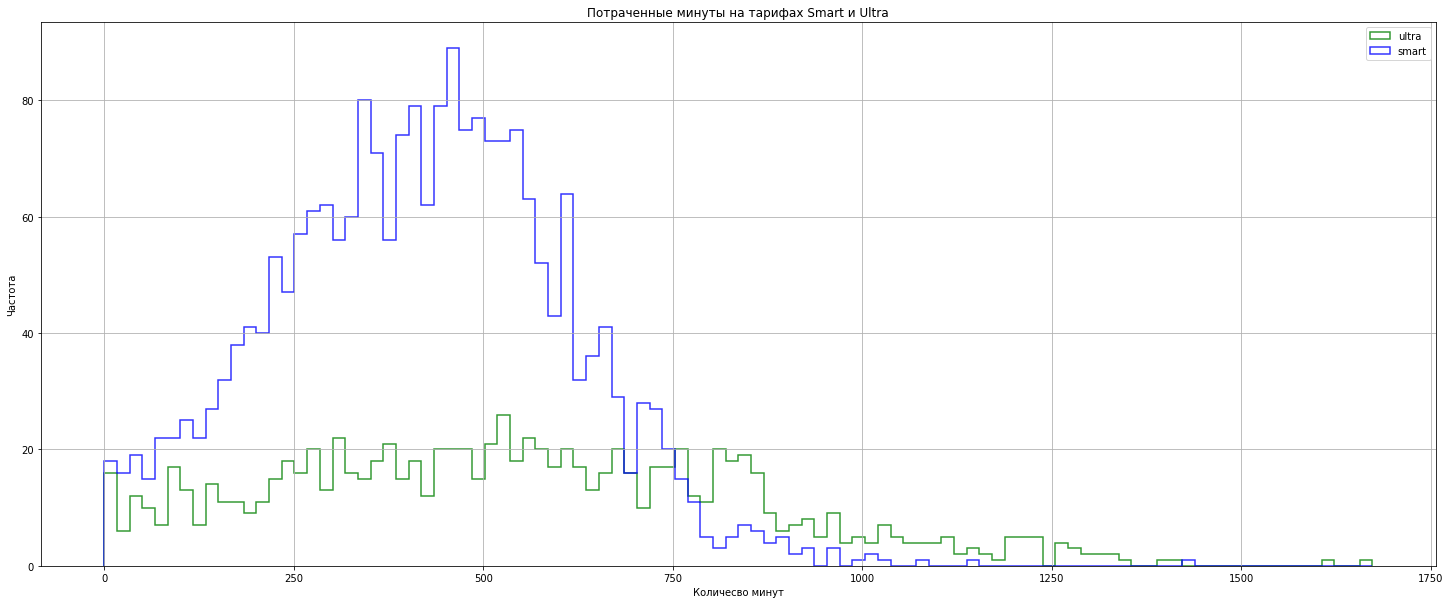

In [41]:
ax = users_stat_ultra.plot(
    kind='hist',
    y='minutes',
    histtype='step',
    figsize=(25, 10),
    color='g',
    range=(0, users_stat_ultra['minutes'].max()),
    bins=100,
    label='ultra',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
users_stat_smart.plot(
    kind='hist',
    y='minutes',
    histtype='step',
    ax=ax,
    figsize=(25, 10),
    color='b',
    range=(0, users_stat_ultra['minutes'].max()),
    bins=100,
    label='smart',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
plt.title('Потраченные минуты на тарифах Smart и Ultra')
plt.ylabel('Частота')
plt.xlabel('Количесво минут')
plt.show()

Распределение количества потраченных минут пользователей тарифа smart похоже на нормальное с явным максимумом, соответствующее среднему значению. Распрделение потраченных минут пользователей тарифа ultra - равномерно "растянуто" без явного максимума

Text(0.5, 0, 'Количесво сообщений')

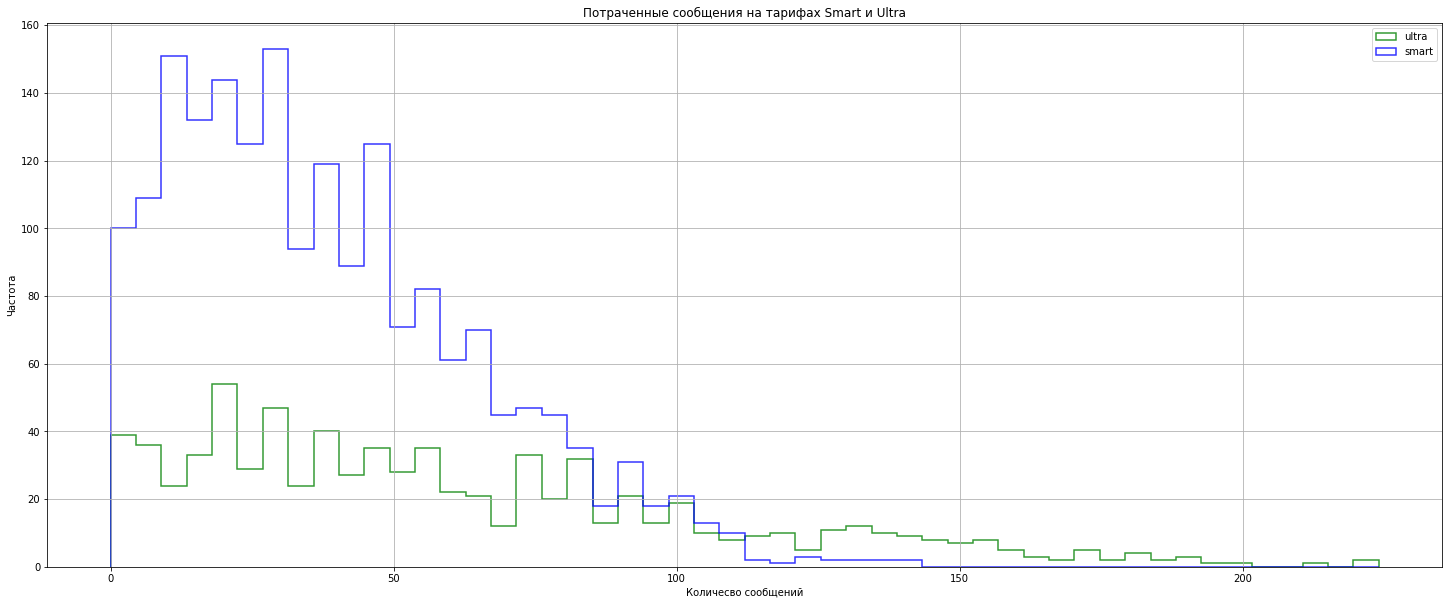

In [42]:
ax = users_stat_ultra.plot(
    kind='hist',
    y='messages',
    histtype='step',
    figsize=(25,10),
    color='g',
    range=(0, users_stat_ultra['messages'].max()),
    bins=50,
    label='ultra',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
users_stat_smart.plot(
    kind='hist',
    y='messages',
    histtype='step',
    ax=ax,
    figsize=(25,10),
    color='b',
    range=(0, users_stat_ultra['messages'].max()),
    bins=50,
    label='smart',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
plt.title('Потраченные сообщения на тарифах Smart и Ultra')
plt.ylabel('Частота')
plt.xlabel('Количесво сообщений')

Распределение количества потраченных сообщений пользователей тарифа smart похоже на нормальное с явным максимумом, соответствующее среднему значению. Распрделение потраченных минут пользователей тарифа ultra - равномерно "растянуто" без явного максимума.

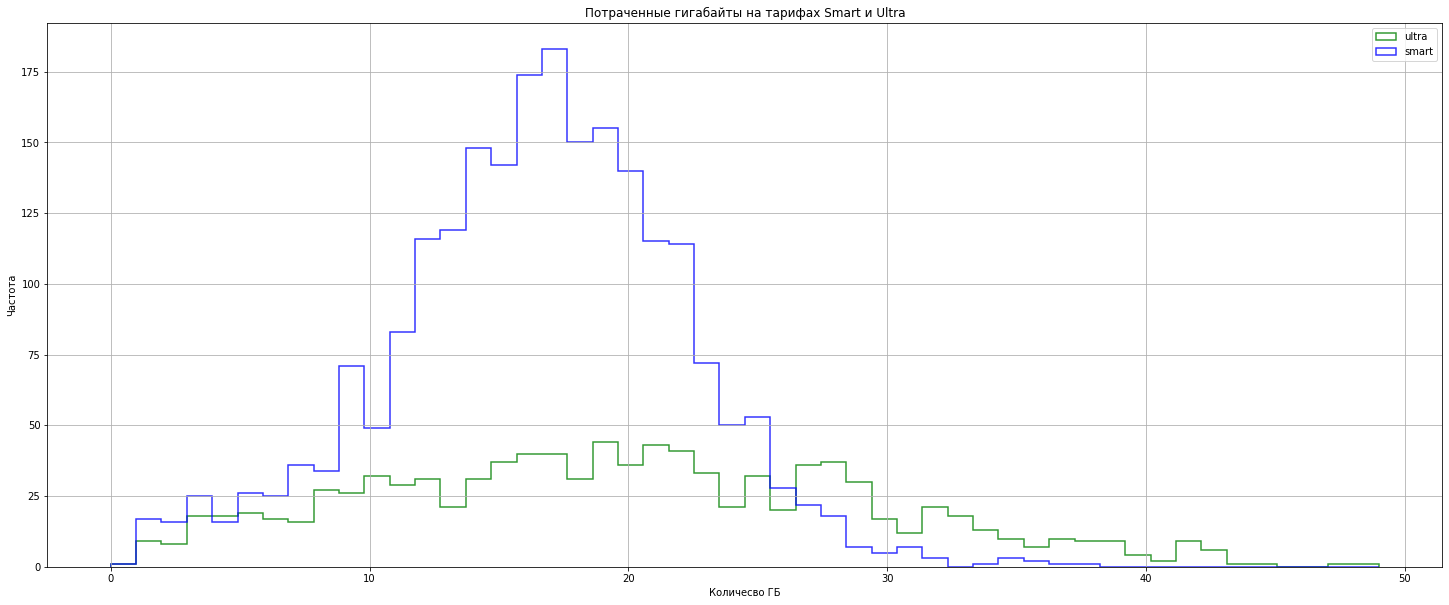

In [43]:
ax = users_stat_ultra.plot(
    kind='hist',
    y='gb_used',
    histtype='step',
    figsize=(25, 10),
    color='g',
    range=(0, users_stat_ultra['gb_used'].max()),
    bins=50,
    label='ultra',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
users_stat_smart.plot(
    kind='hist',
    y='gb_used',
    histtype='step',
    ax=ax,
    figsize=(25, 10),
    color='b',
    range=(0, users_stat_ultra['gb_used'].max()),
    bins=50,
    label='smart',
    grid=True,
    legend=True,
    linewidth=1.5,
    alpha=0.8
)
plt.title('Потраченные гигабайты на тарифах Smart и Ultra')
plt.ylabel('Частота')
plt.xlabel('Количесво ГБ')
plt.show()

Картина аналогична распределению потраченных минут и сообщений.

Как показали диаграммы распределения, поведение пользователей у двух тарифов сильно отличаются.  
Пользователи тарифа ultra примерно одинаково по выборке потрелбяют минуты и сообщения, но пакет интеренета некоторые из них регулярно докупают. Минуты по тарифному плану никто не выговаривает. В пакет включено 3000 минут, а максимальное значение у пользователей данного тарифа 1435 минут.
А вот пользователи тарифа smart между собой отличаются сильнее. На графиках явно видны максимумы и распределение похоже на нормальное. Абоненты часто выходят за рамки предоставленного пакета и докупают минты, смс и мобильный интернет.

## Проверка гипотез

Проверим следующие гипотезы:  
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha зададим самостоятельно.

Проверяем первую гипотезу: 

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза: построим ее так, чтобы применялся знак равенства "Да, средняя выручка пользователей тарифов «Ультра» и «Смарт» равна".  
Тогда альтернативная гипотеза будет звучать так: "Нет, средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна".

Проверим данные гипотезы.

Для этого воспользуемя спеуиальным методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var)

Укажу equal_var = False, поскольку выборки не равные, и посчитанные ранее дисперсии распределения потраченных минут, сообщений и интернет-трафика сильно отличаются, есть все основания предположить что и в данном случае дисперсии не равны.

In [44]:
ultra_revenue = users_stat_ultra['revenue']
smart_revenue = users_stat_smart['revenue']

In [45]:
alpha = .05
results = st.ttest_ind(
    smart_revenue, 
    ultra_revenue, 
    equal_var = False)
print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.2606313931076085e-250
Отвергаем нулевую гипотезу


Данное значние значительно меньше порогового уровеня статистической значимости (обычно это 5%, но тут значительно меньше 1%), в связи с чем можно отказаться от нулевой гипотезы и сделать вывод что средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

Проверяем вторую гипотезу:

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: построим ее так, чтобы применялся знак равенства "Да, средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов".  
Тогда альтернативная гипотеза звучт так: "Нет, средняя выручка пользователей из Москвы не равна средней выручке пользователей из других регионов".

Проверим данные гипотезы.

Для этого воспользуемя спеуиальным методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var)

Укажу аналогично проверке первой гипотезе equal_var = False.

Пороговое значение alpha, аналогично первому варианту возьмем 5%

In [46]:
moscow_revenue = users_stat.query('city == "Москва"')['revenue']
notmoscow_revenue = users_stat.query('city != "Москва"')['revenue']

In [47]:
results = st.ttest_ind(
    moscow_revenue, 
    notmoscow_revenue, 
    equal_var = False)
print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Как показал тест, вторая гипотеза имеет место быть и, вероятно, средняя выручка пользователей из Москвы не отличается от средней выручки пользователя из другого региона страны.

## Общий вывод

В проекте были проведены все необходимые расчеты, проверены гипотезы.

Для пользователей разных тарифов и из разных регионов можно сделать следующие общие выводы:
Пользователи тарифа smart отличаются по выборке сильнее, чем пользователи тарифа ultra. В тарифе smart есть пользователи, которые часто выходят за рамки тарифа и докумают сверх пакета дополнительные минуты, смс-сообщения и трафик интернета. В тарифе ultra большиснтво пользователей не расходует минуты в пакете тарифа, однако в выборке представлены и абоненты, выходящие за рамки пакета по интернету. Возможно компании следует продумать третий тарифный план, для пользователей с большим расходом трафика интернета.

Проверка гипотез показала:  
- гипотеза о равной средней выручке между пользователми тарифов не подтвердилась, что может подтолкнуть на повышение доходности с пользователей тарифа smart, поскольку таких большинство.
- гипотеза о равенстве средней выручки пользользователей из Москвы и регионов подтвердилась, что в свою очередь должно натолкнуть на мысль о повышении доходности от пользователей из Столицы, поскольку считается что данная категория более платежеспособная.  

Как показало исследование более выгодным тарифом для компании оказался "Smart". Он приносит большую выручку и имеет большее количество пользователей. 